In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 06b

## Multiple Hidden Layers Binary output - attempted over-fit 
<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Some basic parameters

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
rng = np.random.default_rng(seed=RANDOM_STATE)

EPOCHS = 50001 # number of cycles to run
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,12),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.coolwarm
plt.rcParams.update(params) # update rcParams

## Helper Functions

In [4]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], X_tr: np.ndarray, y_tr: np.ndarray, X_ts :  np.ndarray, y_ts:  np.ndarray,):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1], 
               c=np.argmax(y_tr, axis = 1), # y_tr has two columns 
               s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    
    
    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1], 
               c=np.argmax(y_ts, axis = 1), # y_tr has two columns ,
                                  s=150, marker = '*',edgecolor='k', cmap=plt.cm.inferno )

In [5]:
# Function to plot history

def fn_plot_hist(hist_df: pd.DataFrame):
    
    '''
    Args:
        hist_df: a dataframe with following columns
            column 0: epoch
            column 1: loss
            column 2: ts_loss
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
    
    # create figure and axis array
    fig, ax = plt.subplots(1,1 , figsize = (15,6)) 

    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    
    
    # Plot Column 0 and 2 (Loss and validation loss)
    hist_df.plot(x = hist_df.columns[0], y = [hist_df.columns[1],  hist_df.columns[2]], 
                 ax = ax,
                 colormap=CMAP) 

    # get minimum values for plotting
    lossmin = hist_df[hist_df.columns[1]].min()
    
    testmin = hist_df[hist_df.columns[2]].min()

    
    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.4, 0.95, txtstr,
            transform=ax.transAxes,
            fontsize=14,
            verticalalignment='top',
            bbox=props)

    # x axis label
    ax.set_xlabel("Epochs")

    # y axis label
    ax.set_ylabel(hist_df.columns[1].capitalize())
    
    # Show grids on the axis
    ax.grid()
    
    plt.tight_layout()

## Generate Data Set
<p style="font-family: Arial; font-size:1.2em">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a>.
</p>

In [6]:
X, y = datasets.make_moons(n_samples=NUM_SAMPLES,
                           shuffle=True,
                           noise=NOISE,
                           random_state=RANDOM_STATE)

In [7]:
data_df = pd.DataFrame(X, columns = ['A', 'B'])
data_df['Target'] = y
#data_df.head()

#data_df.describe()

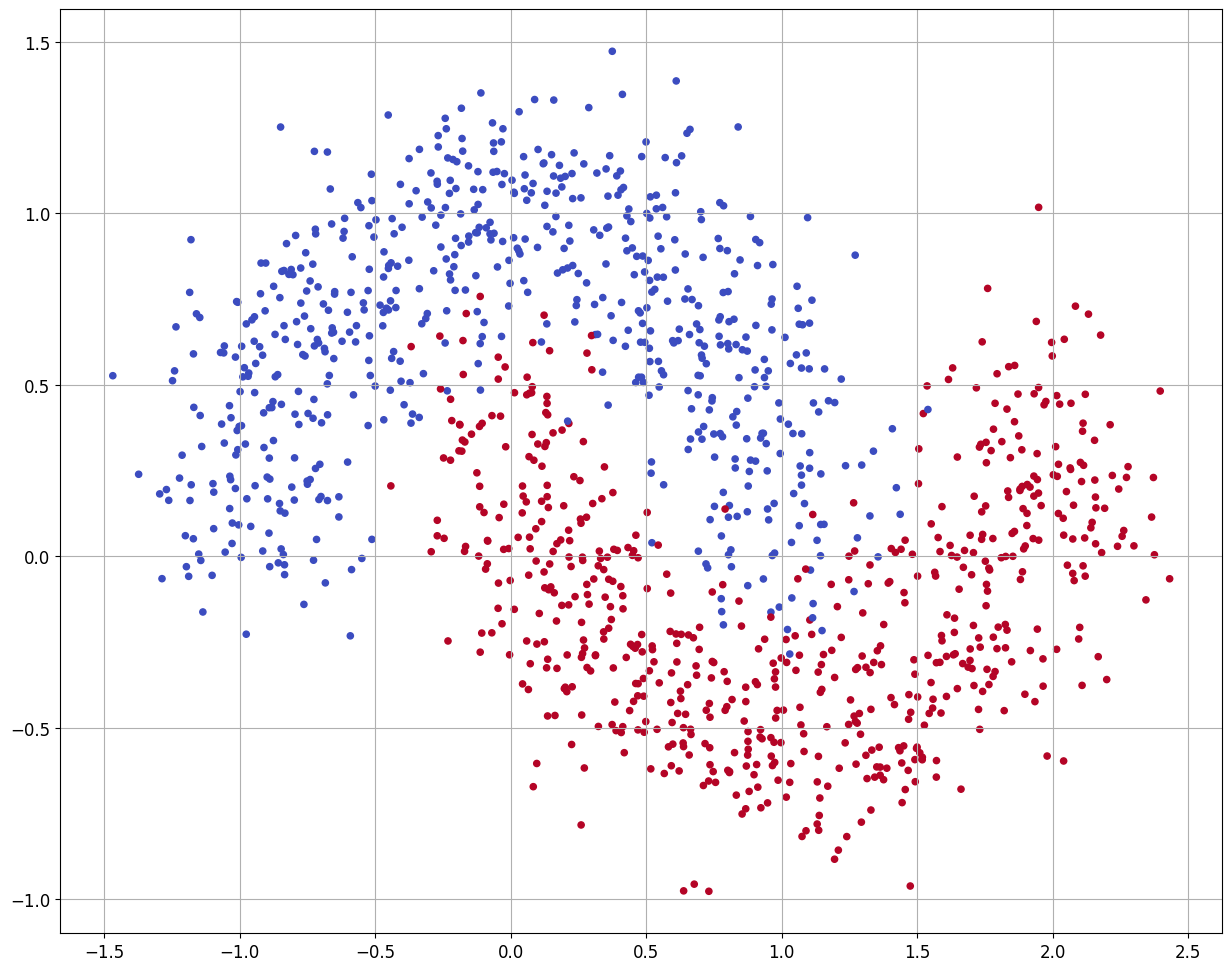

In [8]:
# Plot the data
plt.scatter(X[:,0], X[:,1], s=20, c=y, cmap=CMAP)

plt.grid()

In [9]:
################################
### Make it multiclass data
################################

y = pd.get_dummies(y).to_numpy()
y

array([[False,  True],
       [ True, False],
       [False,  True],
       ...,
       [ True, False],
       [False,  True],
       [ True, False]])

In [10]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024, 2) (256, 2) (256, 2)


# Neural Network


## Recap
<img src='../../images/dnn_nb_s04_fig1.jpg' style='width: 800px' alt = 'Session 1 Figure 1'/>


## Forward Propagation

<img src='../../images/dnn_nb_s04_fig3.jpg' style='width: 800px;' alt = 'Session 4 Figure 2'/>

$
\begin{aligned}
Z^{[1]} & = X . W^{[1]} + b^{[1]} \\
a^{[1]} & = \text{g}(z^{[1]}) \\
\end{aligned}
$

<p style="font-family: Arial; font-size:1.2em;">
    Similarly for second layer.
</p>

$
\begin{aligned}
z^{[2]} & = a^{[1]}. W^{[2]} + b^{[2]} \\
a^{[2]} & = \hat{y} = \mathrm{softmax}(z^{[2]})\\
\end{aligned}
$

<p style="font-family: Arial; font-size:1.2em;">
    Where:
</p>

$
\begin{aligned}
\mathrm{softmax}(z_i) & =  \frac{e^{z_i}}{\sum\limits_{i = 1}^{L} {e^{z_i}}}\\
\end{aligned}
$
    
<p style="font-family: Arial; font-size:1.2em">
    Taking instability of Softmax into account, it is recommended to tweak the formula a bit:<br><br>
</p>


$\mathrm{softmax}(z_i) = \large{\frac{e^{z_i – max\left ( z \right )}}{\sum\limits_{i=1}^{L} e^{z_i}- max\left ( z \right )}}$

    

## Softmax Function for output layer

In [11]:
def fn_softmax(z : np.ndarray) -> np.ndarray:
    
    '''
    Args:
        z : a matrix of z values of shape (m, n_output)
    returns:
        Softmax values of z
    
    '''
    
    exp_scores = np.exp( z - np.max(z) )

    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

## Activation Function for other layers

In [12]:
def fn_activ(z: np.ndarray) -> np.ndarray:
    
    '''
        Args:
           z : array, Aggregated values 
       Return:
           Activations for each z
    '''

    return np.tanh(z)

def fn_activ_prime(a: np.ndarray) -> np.ndarray:
    '''
        Args:
           a : array, Aggregated values 
       Return:
           Derivative, for each a
    '''

    return 1.0 - np.tanh(a)**2

## Multiple hidden layers

<p style="font-family: Arial; font-size:1.2em;"> 
    Moving over to multilayer network. Our data has <strong>two</strong> features. Hence size of input layer will also be two. The output is binary, we can code it as single column as well as double column output. Let's consider following hidden layers:</p>
<table style="font-family: Arial; font-size:1.2em;">
    <tr>
        <th>#</th>
        <th>Layer Number</th>
        <th>Nodes </th>
        <th>Activation </th>
    </tr>
    <tr>
        <td>1</td>
        <td>Input Layer</td>
        <td>2</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>2</td>
        <td>Hidden Layer 1</td>
        <td>5</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>3</td>
        <td>Hidden Layer 2</td>
        <td>5</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>4</td>
        <td>Hidden Layer 3</td>
        <td>4</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>5</td>
        <td>Hidden Layer 4</td>
        <td>3</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>6</td>
        <td>Layer 5 (Output)</td>
        <td>2</td>
        <td>softmax</td>
    </tr>
</table>

<img src='../../images/dnn_nb_s06_fig3.jpg' style='width: 800px' alt = 'Session 6 Figure 3'/>

## Loss Function

We need to minimize the error by adjusting ($Ws, bs$). We call the function that measures our error the <b>loss function</b>. A common choice with the softmax output is the cross-entropy loss. The loss for predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -[y_i.log\hat{y_i} + (1 - y_i) . log(1-\hat{y_i})]
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}[y_i.log\hat{y}_i + (1-y_i) . log(1-\hat{y}_i)]
\end{aligned}
$


We can use gradient descent to find its minimum. For purpose of this Session, let's use it in its simplest form - <b>batch gradient descent with fixed learning rate</b>.

## Forward Propogation

<img src='../../images/dnn_nb_s06_fig4.jpg' style='width: 800px' alt = 'Session 6 Figure 4'/>

                                                               
$
\begin{aligned}
z^{[l]} & = a^{[l-1]} . W^{[l]} + b^{[l]}\\
a^{[l]} & = \text{g}(z^{[l]})\text{ for hidden layers} \\
a^{[l]} & = \mathrm{softmax}(z^{[l]})\text{ for output layer}  \\
\end{aligned}
$

## Loss function

In [13]:
def calculate_loss(model : dict, 
                   X_l: np.ndarray, 
                   y_l: np.ndarray) -> np.float64:
    '''
    Args:
        model: dictionay object containing weights and biases
        X_l: Feature Matrix
        y_l: Labels array
    Returns:
        Average loss
    '''
    
    # Extract Weights and biases from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    # number of examples
    m = X_l.shape[0]
    
    #***********************************
    # Layer 1
    z1 = X_l.dot(W1) + b1  # Aggregation
    a1 = fn_activ(z1)     # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2 # Aggregation
    a2 = fn_activ(z2)     # Activation

    # Layer 3
    z3 = a2.dot(W3) + b3 # Aggregation
    a3 = fn_activ(z3)     # Activation

    # Layer 4
    z4 = a3.dot(W4) + b4 # Aggregation
    a4 = fn_activ(z4)     # Activation

    # Layer 5
    z5 = a4.dot(W5) + b5 # Aggregation
    a5 = fn_softmax(z5)  # softmax activation
    #***********************************
    
    # Calculating the loss
    data_loss = -(y_l * np.log(a5) + (1 - y_l) * np.log(1 - a5) ).sum() 

    return 1./m * data_loss

## Predict Function
<p style="font-family: Arial; font-size:1.2em">
For predictions, we will simply be using the forward propagation. No need to iterate or calculate the back propogation for supervised learning.
</p>

In [14]:
def predict(model : dict, 
            X_p: np.ndarray) -> np.ndarray:
    '''
     Args:
         model
         X_p: input features
    Returns:
        Predictions against the instances
         
    '''
    # Extract Weights and biases from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    #***********************************
    # Layer 1
    z1 = X_p.dot(W1) + b1  # Aggregation
    a1 = fn_activ(z1)     # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2 # Aggregation
    a2 = fn_activ(z2)     # Activation

    # Layer 3
    z3 = a2.dot(W3) + b3 # Aggregation
    a3 = fn_activ(z3)     # Activation

    # Layer 4
    z4 = a3.dot(W4) + b4 # Aggregation
    a4 = fn_activ(z4)     # Activation

    # Layer 5
    z5 = a4.dot(W5) + b5 # Aggregation
    a5 = fn_softmax(z5)  # softmax activation
    #***********************************
    
    return np.argmax(a5, axis = 1)

## Backpropogation
<img src='../../images/dnn_nb_s04_fig4.jpg' style='width: 800px' alt = 'Session 4 Figure 4'/>

<img src='../../images/dnn_nb_s06_fig4.jpg' style='width: 800px' alt = 'Session 6 Figure 4'/>

#### For last layer

$
\begin{aligned}
\partial{z^{[L]}}  & = a^{[L]} - y \\
\partial{W^{[L]}}  & = \frac{1}{m} a^{[L-1]T}\circ \partial{z^{[L]}} \\
\partial{b^{[L]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[L]}}, axis = 0, keepdims = True) \\
\end{aligned}
$

#### For any other layer

$
\begin{aligned}
\partial{a^{[l]}}  & = \partial{z^{[l+1]}} . \partial{W^{[l+1]T}}\\
\partial{z^{[l]}}  & = \partial{a^{[l]}} * ( 1-a^{[l]}**2)\\
\partial{W^{[l]}}  & = \frac{1}{m} a^{[l-1]T}\circ \partial{z^{[l]}} \\
\partial{b^{[l]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[l]}}, axis = 0, keepdims = True) \\
\\
\end{aligned}
$

## Build Model

In [15]:
def build_model(param: list,
                X_tr : np.ndarray, 
                y_tr : np.ndarray, 
                X_ts : np.ndarray, 
                y_ts : np.ndarray, 
                epochs: np.int64 = EPOCHS, 
                alpha: np.float64 = ALPHA) -> dict:
    '''
    Args:
        param : Number of nodes in all (input layer, hidden layer, output layer)
        X_tr : Train features
        y_tr : Train targets (labels)
        X_ts : Test features
        y_ts : Trainig targets (labels)
        epochs : Number of passes through the training data for gradient descent
        alpha : learning rate
         
    Returns:
        Model: Dictionary object containing weights and biases
    '''
    # number of examples
    m = X_tr.shape[0]
    
    # Initialize the weights and biases to random values. We need to learn these.
    W1 = rng.random((param['nn_hdim'][0], param['nn_hdim'][1])) / np.sqrt(param['nn_hdim'][0])
    b1 = np.zeros((1, param['nn_hdim'][1]))
    
    W2 = rng.random((param['nn_hdim'][1], param['nn_hdim'][2])) / np.sqrt(param['nn_hdim'][1])
    b2 = np.zeros((1, param['nn_hdim'][2]))
    
    W3 = rng.random((param['nn_hdim'][2], param['nn_hdim'][3])) / np.sqrt(param['nn_hdim'][2])
    b3 = np.zeros((1, param['nn_hdim'][3]))
    
    W4 = rng.random((param['nn_hdim'][3], param['nn_hdim'][4])) / np.sqrt(param['nn_hdim'][3])
    b4 = np.zeros((1, param['nn_hdim'][4]))
   
    W5 = rng.random((param['nn_hdim'][4], nn_output_dim)) / np.sqrt(param['nn_hdim'][4])
    b5 = np.zeros((1, nn_output_dim))
    
    # lists to collect losses
    curr_loss = 0
    loss = []
    t_curr_loss = 0
    t_loss = []
    epoch = []
    
    for i in range(0, epochs):
        
        #### Forward ------------------------------
        # Layer 1
        z1 = X_tr.dot(W1) + b1  # aggregation
        a1 = fn_activ(z1)     # activation
        
        # Layer 2
        z2 = a1.dot(W2) + b2 # aggregation
        a2 = fn_activ(z2)     # activation
        
        # Layer 3
        z3 = a2.dot(W3) + b3 # aggregation 
        a3 = fn_activ(z3)     # activation
        
        # Layer 4
        z4 = a3.dot(W4) + b4 # aggregation 
        a4 = fn_activ(z4)     # activation
        
        # Layer 5
        z5 = a4.dot(W5) + b5 # aggregation
        a5 = fn_softmax(z5)  # activation

        
        ### Back Prop ------------------------------
        dz5 = a5- y_tr
        
        # Layer 5
        dW5 = (a4.T).dot(dz5) 
        db5 = np.sum(dz5, axis=0, keepdims=True) # db5 is vertical sum of dz5
        da4 = dz5.dot(W5.T)
        
        #Layer 4
        dz4 = da4 * fn_activ_prime(z4)        
        dW4 = (a3.T).dot(dz4)        
        db4 = np.sum(dz4, axis=0, keepdims=True)
        da3 = dz4.dot(W4.T)
        
        #Layer 3
        dz3 = da3 * fn_activ_prime(z3)
        dW3 = (a2.T).dot(dz3)
        db3 = np.sum(dz3, axis=0, keepdims=True)
        da2 = dz3.dot(W3.T)
        
        #Layer 2
        dz2 = da2 * fn_activ_prime(z2)        
        dW2 = (a1.T).dot(dz2)        
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1= dz2.dot(W2.T)
        
        #Layer 1
        dz1 = da1 * fn_activ_prime(z1)
        dW1 = (X_tr.T).dot(dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)
        
        
        # Weights update
        W1 += -alpha * dW1 /m
        b1 += -alpha * db1 /m
        
        W2 += -alpha * dW2 /m
        b2 += -alpha * db2 /m
        
        W3 += -alpha * dW3 /m
        b3 += -alpha * db3 /m
        
        W4 += -alpha * dW4 /m
        b4 += -alpha * db4 /m
        
        W5 += -alpha * dW5 /m
        b5 += -alpha * db5 /m
        
        model = { 
            'W1': W1, 'b1': b1,
            'W2': W2, 'b2': b2,
            'W3': W3, 'b3': b3,
            'W4': W4, 'b4': b4,
            'W5': W5, 'b5': b5}
        
        if i % 10 == 0 :
            
            epoch.append(i)
            
            curr_loss = calculate_loss(model, X_tr, y_tr)
            loss.append(curr_loss)
            
            t_curr_loss = calculate_loss(model, X_ts, y_ts)
            t_loss.append(t_curr_loss)
            
            
        # Print the loss.
        if i % 1000 == 0:
            print("Loss after iteration %5i: %.5f" %(i, curr_loss))
    
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    loss_hist['test_loss'] = t_loss
    
    return model

In [16]:
# assemble all parameters in a dictionary object
layer_param = {}
layer_param['nn_hdim'] = [X_train.shape[1],50,50,40,30]
loss_hist = {}

In [17]:
alpha = ALPHA
epochs = EPOCHS
nn_output_dim = y_train.shape[1]
model = build_model(layer_param, X_train, y_train, X_test, y_test, epochs, alpha ) 

Loss after iteration     0: 1.37756
Loss after iteration  1000: 0.91954
Loss after iteration  2000: 0.58240
Loss after iteration  3000: 0.15083
Loss after iteration  4000: 0.14010
Loss after iteration  5000: 0.13668
Loss after iteration  6000: 0.13488
Loss after iteration  7000: 0.13363
Loss after iteration  8000: 0.13265
Loss after iteration  9000: 0.13181
Loss after iteration 10000: 0.13105
Loss after iteration 11000: 0.13034
Loss after iteration 12000: 0.12964
Loss after iteration 13000: 0.12895
Loss after iteration 14000: 0.12826
Loss after iteration 15000: 0.12755
Loss after iteration 16000: 0.12683
Loss after iteration 17000: 0.12607
Loss after iteration 18000: 0.12525
Loss after iteration 19000: 0.12431
Loss after iteration 20000: 0.12321
Loss after iteration 21000: 0.12193
Loss after iteration 22000: 0.12048
Loss after iteration 23000: 0.11893
Loss after iteration 24000: 0.11734
Loss after iteration 25000: 0.11573
Loss after iteration 26000: 0.11406
Loss after iteration 27000: 

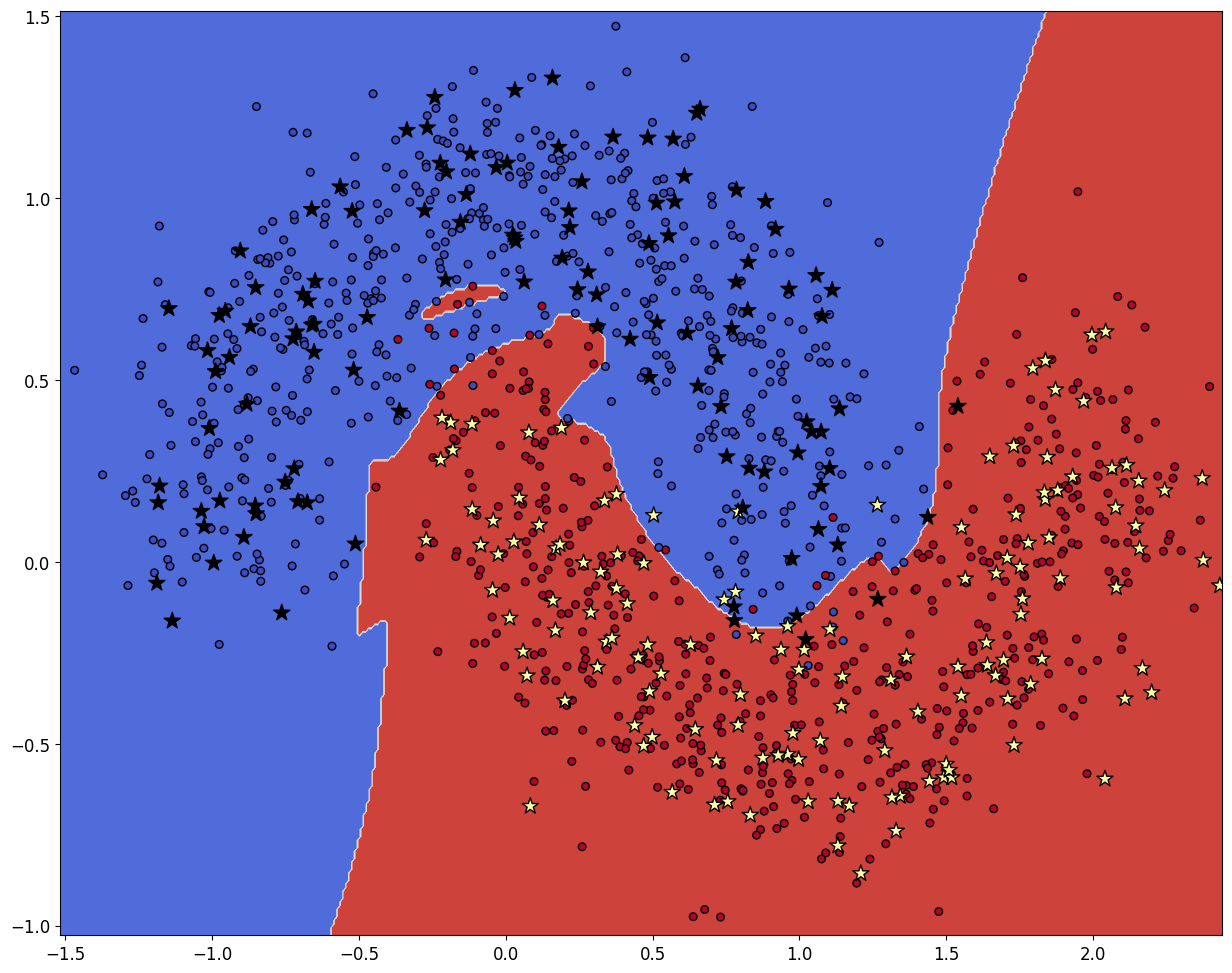

In [18]:
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train,  X_test, y_test) # plot decision boundary for this plot

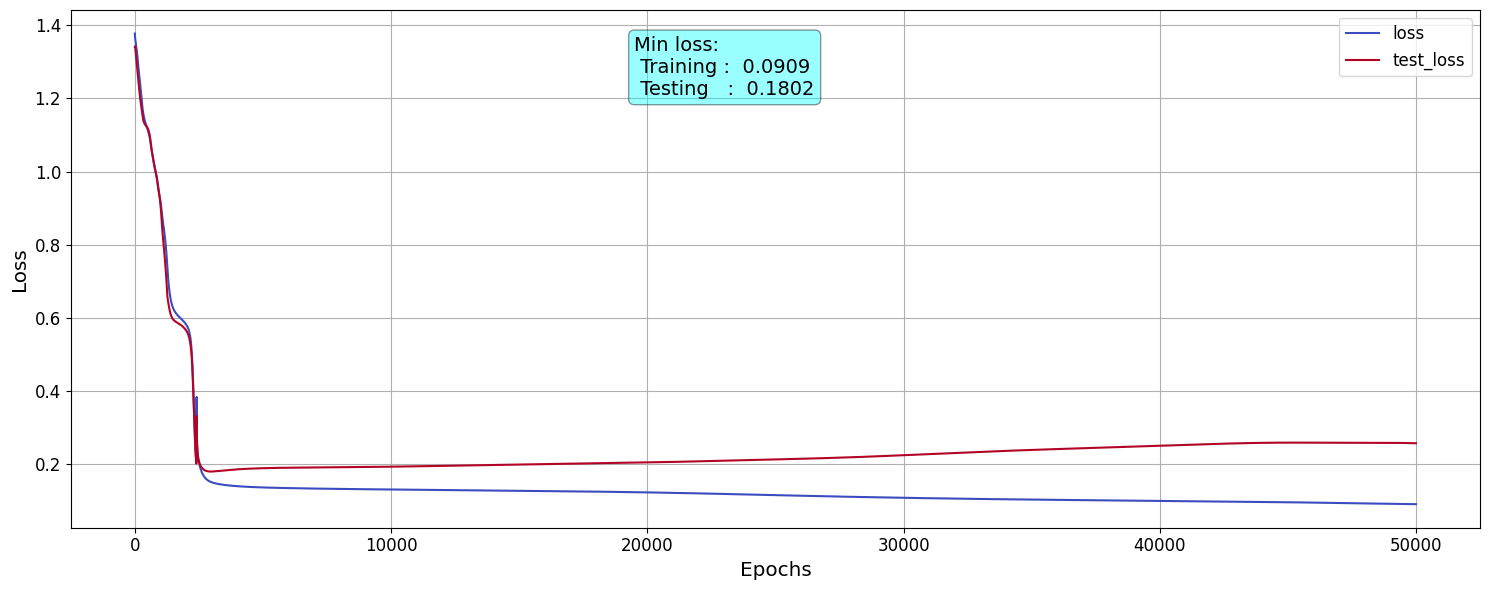

In [19]:
loss_df = pd.DataFrame(loss_hist)

fn_plot_hist(loss_df)

In [20]:
def fn_make_predicitions(pred_func, X):
    y_pred = pred_func(X)
    return y_pred

In [21]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_train)
print('Accuracy score on Train Data :', accuracy_score(np.argmax(y_train, axis = 1), y_pred))

Accuracy score on Train Data : 0.974609375


In [22]:
print(classification_report(np.argmax(y_train, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       522
           1       0.98      0.97      0.97       502

    accuracy                           0.97      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.97      0.97      0.97      1024



In [23]:
cm_train  = confusion_matrix(np.argmax(y_train, axis = 1), y_pred)
cm_train

array([[512,  10],
       [ 16, 486]])

In [24]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_test)

print('Accuracy score on Test Data :', accuracy_score(np.argmax(y_test, axis = 1), y_pred))

Accuracy score on Test Data : 0.96484375


In [25]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.97      0.96      0.97       138

    accuracy                           0.96       256
   macro avg       0.96      0.96      0.96       256
weighted avg       0.96      0.96      0.96       256



In [26]:
cm_test  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
cm_test

array([[114,   4],
       [  5, 133]])

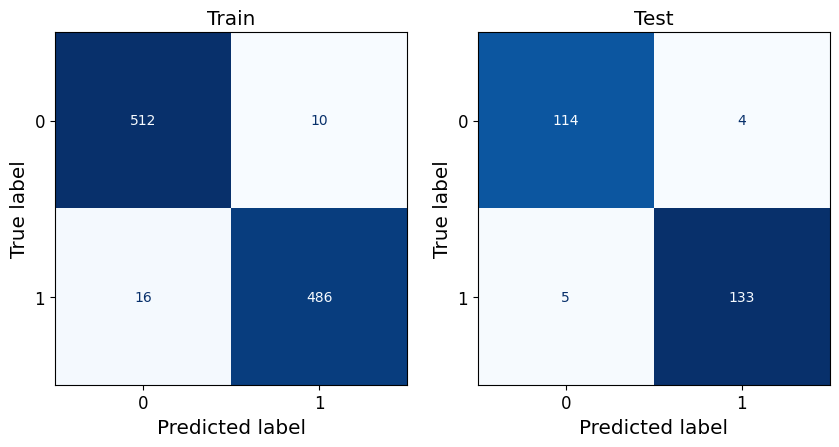

In [27]:
fig, axes = plt.subplots(1,2, figsize = (10,5))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=[0,1])

disp.plot(ax = axes[0], cmap = 'Blues', colorbar=False)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=[0,1])

disp.plot(ax = axes[1], cmap = 'Blues', colorbar=False)

axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show();